# Import libraries

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tsai.inference import load_learner
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import data

In [2]:
# CO2, Temperature and Humidity values measured every minute in the greenhouse
df = pd.read_csv('data_week.csv', index_col=0)
df.head()

,CO2 (ppm),Temperature (C),Humidity (%)
Date Time,,,
2023-03-16 11:35:30,456,22.67,31.21
2023-03-16 11:36:30,438,21.58,33.16
2023-03-16 11:37:30,445,21.19,33.38
2023-03-16 11:38:30,446,21.09,32.49
2023-03-16 11:39:30,446,21.02,33.16


# Data preprocessing

In [3]:
# drop the variables into the same range
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df.values), index=df.index, columns=df.columns)

In [4]:
# drop the last value and save X variable
X = df.drop(df.index[-1])

# get all value except first value and save Y variable
Y = pd.DataFrame(df.values[1:], index=df.index[:-1], columns=['Y_CO2','Y_Temperature','Y_Humidity'])

In [5]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.3, shuffle=False)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8180, 3) (8180, 3) (3507, 3) (3507, 3)


# Import models

In [6]:
ann = load_model('models/ann.h5')
cnn = load_model('models/cnn.h5')
lstm = load_model('models/lstm.h5')
tsai = load_learner('models/tsai.pkl')

In [7]:
# prediction
preds = {
    'tsai': tsai.get_X_preds(X_test.reshape((X_test.shape[0], X_test.shape[1],1)),
                             y_test.reshape((y_test.shape[0], y_test.shape[1],1)))[0].numpy(),
    'cnn': cnn.predict(X_test),
    'ann': ann.predict(X_test),
    'lstm': lstm.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1])))
}

110/110 [==============================] - 1s 3ms/step


In [8]:
# MinMaxScaler inverse transform
for key,value in preds.items():
    preds[key] = scaler.inverse_transform(value)
    
y_test = scaler.inverse_transform(y_test)

# Evaluation

In [9]:
for key,pred in preds.items():
    print(key, end='\n****\n')
    print('Mean absolute error:',mean_absolute_error(y_test, pred))
    print('Mean squared error:',mean_squared_error(y_test, pred))
    print('Root mean squared error:',mean_squared_error(y_test, pred)**(1/2))
    print('Coefficient of determination (r2 score):',r2_score(y_test, pred), end='\n----------------------------------------\n')

tsai
****
Mean absolute error: 5.194604570403116
Mean squared error: 76.65264504346484
Root mean squared error: 8.75514962998719
Coefficient of determination (r2 score): 0.9837051312925512
----------------------------------------
cnn
****
Mean absolute error: 2.2369070762269527
Mean squared error: 18.28279231007775
Root mean squared error: 4.2758381997074855
Coefficient of determination (r2 score): 0.9864505881363138
----------------------------------------
ann
****
Mean absolute error: 1.4699390606517166
Mean squared error: 8.52685945796958
Root mean squared error: 2.9200786732500172
Coefficient of determination (r2 score): 0.9872773861066766
----------------------------------------
lstm
****
Mean absolute error: 1.7397742465638972
Mean squared error: 10.672152143070697
Root mean squared error: 3.2668260044071364
Coefficient of determination (r2 score): 0.9877220046254326
----------------------------------------


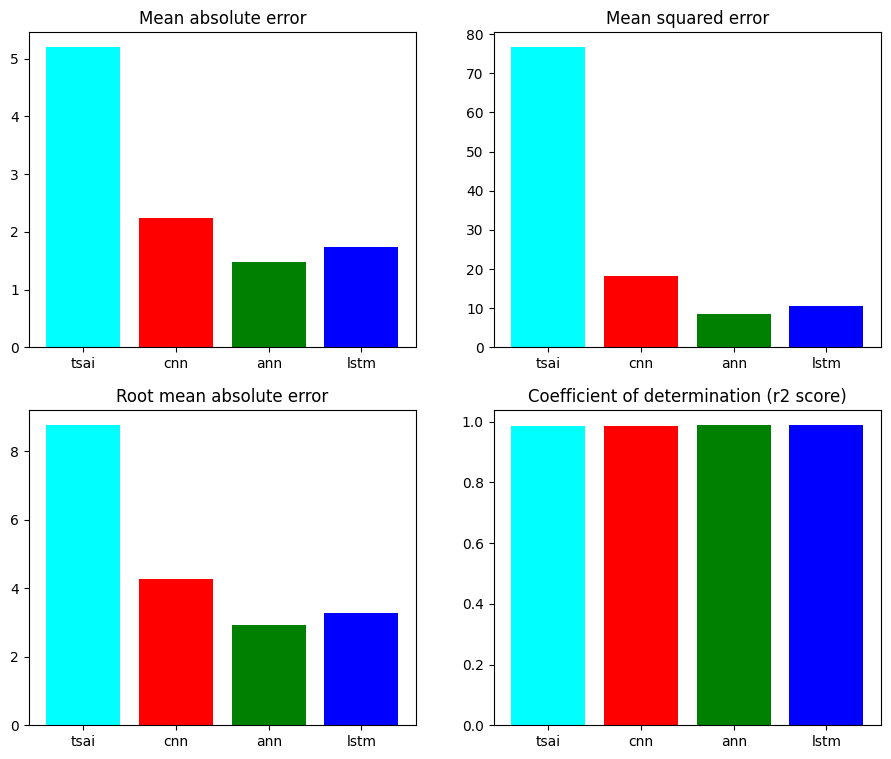

In [10]:
fig, ax = plt.subplots(2,2, figsize=(11,9))

ax[0,0].set_title('Mean absolute error')
ax[0,0].bar(preds.keys(), [mean_absolute_error(y_test, pred) for pred in preds.values()], color=['cyan', 'red', 'green', 'blue'])

ax[0,1].set_title('Mean squared error')
ax[0,1].bar(preds.keys(), [mean_squared_error(y_test, pred) for pred in preds.values()], color=['cyan', 'red', 'green', 'blue'])

ax[1,0].set_title('Root mean absolute error')
ax[1,0].bar(preds.keys(), [mean_squared_error(y_test, pred)**(1/2) for pred in preds.values()], color=['cyan', 'red', 'green', 'blue'])

ax[1,1].set_title('Coefficient of determination (r2 score)')
ax[1,1].bar(preds.keys(), [r2_score(y_test, pred) for pred in preds.values()], color=['cyan', 'red', 'green', 'blue'])
plt.show()

## CO2

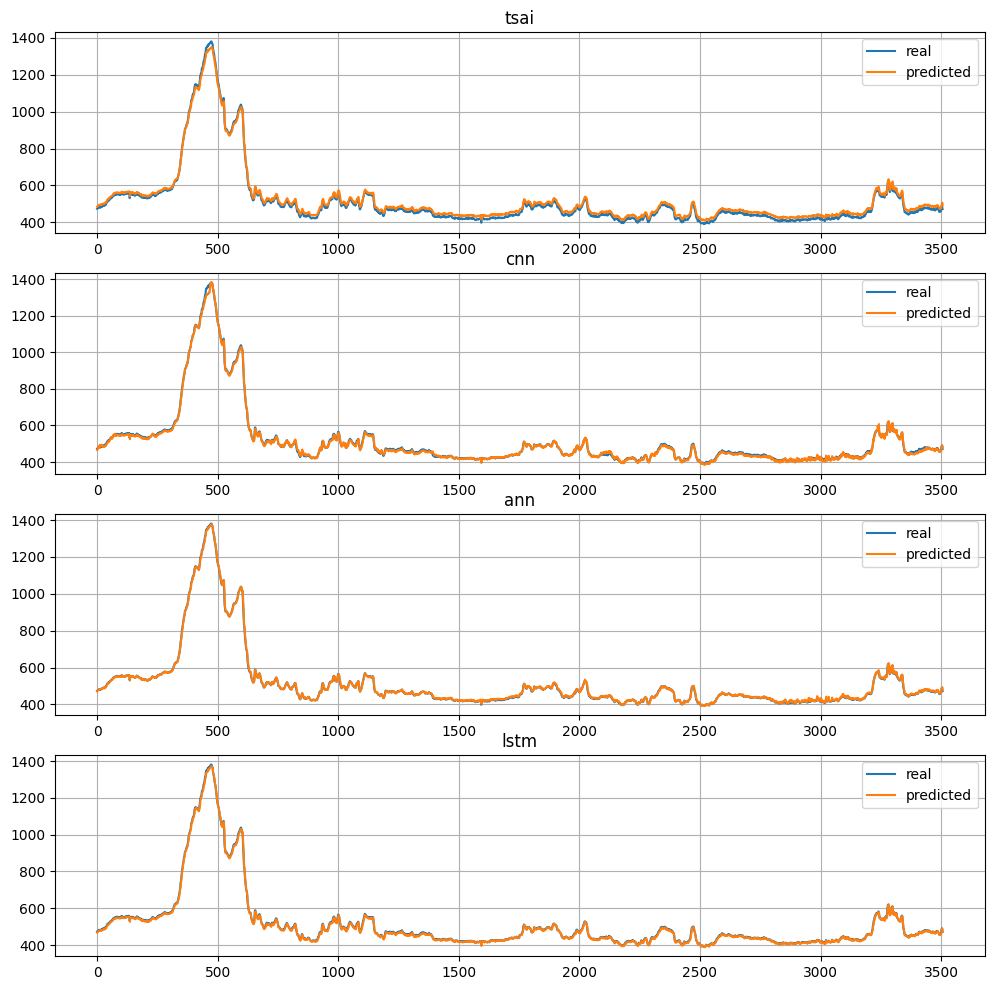

In [11]:
fig, ax = plt.subplots(4, figsize=(12,12))

i = 0
for key,value in preds.items():
    ax[i].set_title(key)
    ax[i].plot(y_test[:,0])
    ax[i].plot(value[:,0])
    ax[i].grid()
    ax[i].legend(['real', 'predicted'], loc='upper right')
    i += 1
plt.show()

## Temperature

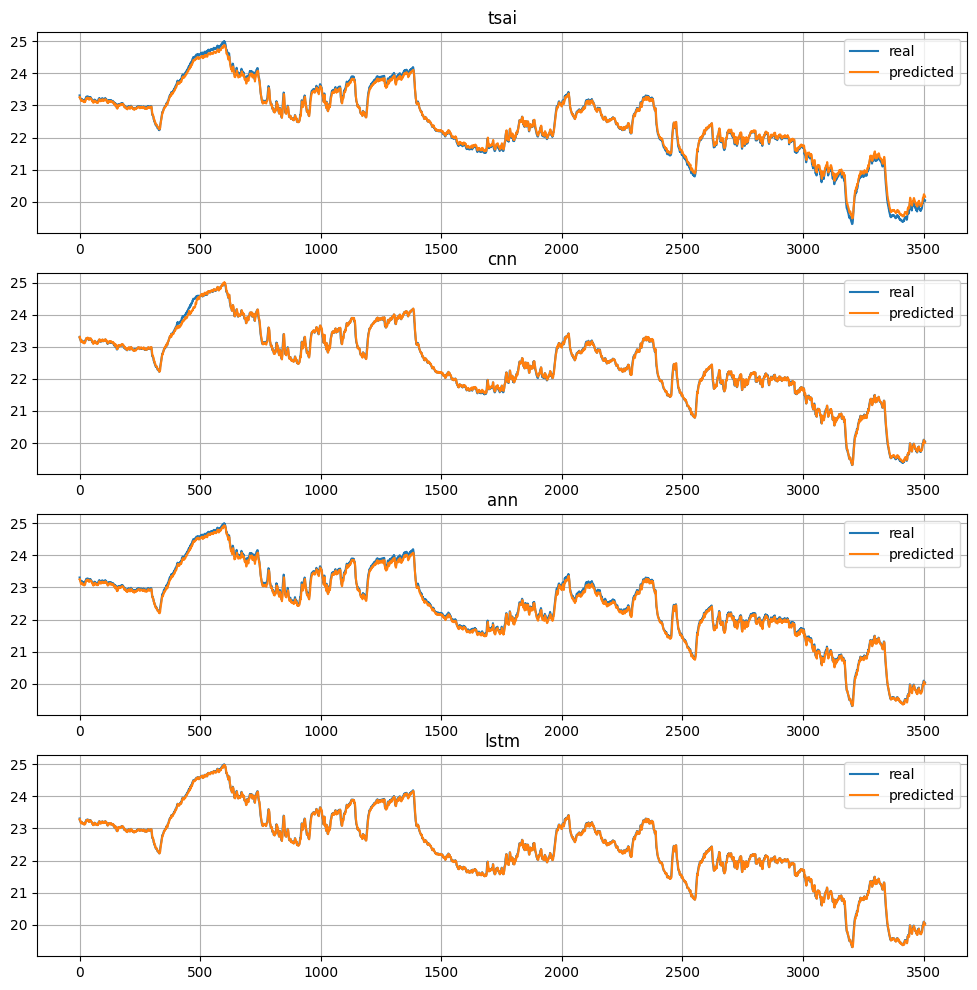

In [12]:
fig, ax = plt.subplots(4, figsize=(12,12))

i = 0
for key,value in preds.items():
    ax[i].set_title(key)
    ax[i].plot(y_test[:,1])
    ax[i].plot(value[:,1])
    ax[i].grid()
    ax[i].legend(['real', 'predicted'], loc='upper right')
    i += 1
plt.show()

## Humidity

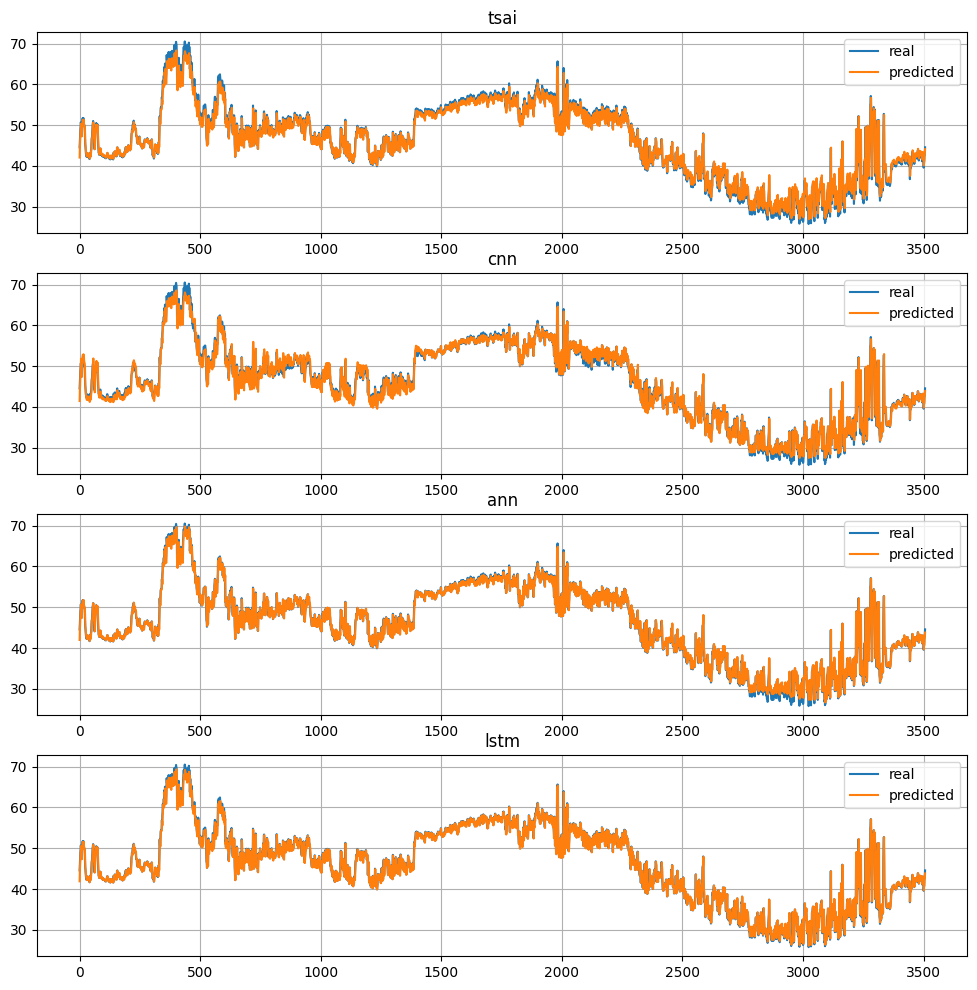

In [13]:
fig, ax = plt.subplots(4, figsize=(12,12))

i = 0
for key,value in preds.items():
    ax[i].set_title(key)
    ax[i].plot(y_test[:,2])
    ax[i].plot(value[:,2])
    ax[i].grid()
    ax[i].legend(['real', 'predicted'], loc='upper right')
    i += 1
plt.show()